In [1]:
import sys
import os
from pathlib import Path
from joblib import Parallel, delayed
from datetime import datetime
import time

import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
from sklearn.cluster import KMeans

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

print(sys.version)

3.8.20 | packaged by conda-forge | (default, Sep 30 2024, 17:52:49) 
[GCC 13.3.0]


This notebook needs to be run in an eviroment with installed SEACells package.

In [2]:
import SEACells


findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [ ]:
os.chdir('/home/kl467102/thesis')

In [4]:
%matplotlib inline

sns.set_style('ticks')
mpl.rcParams['figure.figsize'] = [4, 4]
mpl.rcParams['figure.dpi'] = 100


In step 3 we create a set of downsampled datasets over a grid of parameter. Configuration include: 

* parameters to match the BEELINE - like workflow: a list of TFs, a file with reference network, number of top HVGs and whether to use TFs

* parameters for the metcell generation: a list of `k` values, or average number of cells per metacell.

In [5]:
# --- Configuration ---
os.chdir('/home/kl467102/thesis')
tf_file = '/home/kl467102/Beeline-238/inputs/hHep/human-tfs.csv'
network_file = '/home/kl467102/string_dir/9606_protein_links_gene_names_combined_score_700.csv'
network_name = 'STRING12'
beeline_dir = '/home/kl467102/thesis/BEELINE/'
beeline_dir = Path(beeline_dir)


dataset_name = 'buenrostro18'
n_top_hvg = 1000
include_hv_tfs = True
tfs_suffix = 'TFs' if include_hv_tfs else ''
output_dir = beeline_dir / 'inputs' / dataset_name
os.makedirs(output_dir, exist_ok=True)

#average number of cells per metacell
#k_list = [3, 5, 10, 20, 50, 100, 300]
#k_list = [100, 300]
k_list = [3, 5, 10, 20, 50]



## Load data

As suggestedin by the SEACells authors, as input for metacell generation we provide an AnnData after normalization and logarithmization, but keeping raw counts for potential downstream analyses.

In [6]:
adata_path  = '/home/kl467102/thesis/BEELINE/inputs/buenrostro18/buenrostro18.h5ad'
adata_rna = sc.read(adata_path)

In [7]:
print(f"Initial AnnData shape: {adata_rna.shape}") # (cells, genes)

print(f"Reading TF list: {tf_file}")
tfs_df = pd.read_csv(tf_file, header=0)
all_known_tfs = set(tfs_df[tfs_df.columns[0]])

print(f"Reading network: {network_file}")
net_df = pd.read_csv(network_file)
print(f"Initial network shape: {net_df.shape}")


Initial AnnData shape: (13779, 12558)
Reading TF list: /home/kl467102/Beeline-238/inputs/hHep/human-tfs.csv
Reading network: /home/kl467102/string_dir/9606_protein_links_gene_names_combined_score_700.csv
Initial network shape: (472000, 2)


/home/kl467102/miniconda3/envs/seacells/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


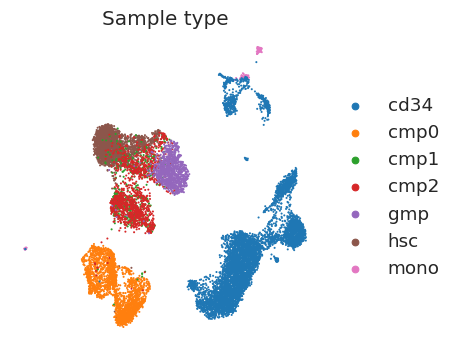

In [8]:
sc.pl.umap(adata_rna, color="sample_type", frameon=False,  title='Sample type')

In [9]:
adata_normalized = adata_rna.copy()
n_cells = adata_normalized.shape[0]
datasets = []

## KMEANS clustering and metacells

In [10]:

def make_metacells(adata, n_clusters, method='sum'):
    # Compute PCA if not already done
    if 'X_pca' not in adata.obsm:
        sc.tl.pca(adata, svd_solver='arpack')
    X = adata.obsm['X_pca']

    # Cluster cells into n_clusters using KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    labels = kmeans.labels_

    metacell_exprs = []
    metacell_names = []

    for cluster_id in range(n_clusters):
        idxs = np.where(labels == cluster_id)[0]
        expr_block = adata.X[idxs]
        if method == 'mean':
            meta_expr = expr_block.mean(axis=0)
        elif method == 'sum':
            meta_expr = expr_block.sum(axis=0)
        else:
            raise ValueError("method must be 'mean' or 'sum'")

        if sp.issparse(meta_expr):
            meta_expr = meta_expr.A1
        elif hasattr(meta_expr, "A1"):
            meta_expr = meta_expr.A1
        else:
            meta_expr = np.asarray(meta_expr).ravel()

        metacell_exprs.append(meta_expr)
        metacell_names.append(f"meta_{cluster_id}")

    X_meta = np.vstack(metacell_exprs)
    meta_adata = sc.AnnData(X=X_meta)
    meta_adata.var_names = adata.var_names
    meta_adata.obs_names = metacell_names

    return meta_adata, labels, n_clusters


In [11]:
results_summary = []

In [12]:
for k in k_list:
    print(f"\n--- Running pipeline with k = {k} ---")
    n = n_cells // k
    param_prefix = output_dir / f"{dataset_name}-KMeans-nmc{n}-avg{k}_{network_name}_{n_top_hvg}{tfs_suffix}"
    os.makedirs(param_prefix, exist_ok=True)
    # Copy original AnnData to avoid in-place modification
    adata = adata_normalized.copy()

    meta_adata, labels, n_clusters = make_metacells(adata, n, method='sum')
    sc.pp.normalize_total(meta_adata, target_sum=1e4)
    sc.pp.log1p(meta_adata)
    sc.pp.highly_variable_genes(meta_adata, n_top_genes=None)

    #PROCEED WITH THE BEELINE-LIKE FEAUTRE SELECTION AND NETWORK FILTERING

    default_mask = adata.var['highly_variable'].copy()
    n_default = default_mask.sum()
    print(f"Default HVGs: {n_default}")
    # Cutoff HVGs
    sc.pp.highly_variable_genes(adata, n_top_genes=n_top_hvg)
    cutoff_mask = adata.var['highly_variable'].copy()
    n_cutoff = cutoff_mask.sum()
    # Include TFs
    tf_mask = adata.var_names.isin(all_known_tfs)
    tf_in_default = default_mask & tf_mask
    n_tf_default = tf_in_default.sum()
    combined = cutoff_mask.copy()
    if include_hv_tfs:
        combined |= tf_in_default
    if include_hv_tfs:
        adata_subset = meta_adata[:, combined].copy()
    else:
        adata_subset = meta_adata[:, adata.var['highly_variable']].copy()
    expr_df = pd.DataFrame(adata_subset.X, index=adata_subset.obs_names, columns=adata_subset.var_names).T
    # Filter network

    filtered_net_df = net_df[
        net_df['Gene1'].isin(adata_subset.var.index) &
        net_df['Gene2'].isin(adata_subset.var.index)
    ].copy()
    filtered_net_df = filtered_net_df[filtered_net_df['Gene1'] != filtered_net_df['Gene2']]
    filtered_net_df.drop_duplicates(keep='first', inplace=True)
    expr_file = param_prefix / 'ExpressionData.csv'
    expr_df.to_csv(expr_file, index=True)
    filtered_network_filename = param_prefix / 'refNetwork.csv'
    filtered_net_df.to_csv(filtered_network_filename, index=False)

    datasets.append(param_prefix.name)
    
    results_summary.append({
        'n_cells': adata_subset.n_obs,
        'n_genes': adata_subset.n_vars,
        'k': k,
        'n_clusters': n_clusters,
        'labels': labels,
    })

# Display summary table
summary_df = pd.DataFrame(results_summary)
display(summary_df)
print(summary_df)



--- Running pipeline with k = 3 ---


/home/kl467102/miniconda3/envs/seacells/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Default HVGs: 1182

--- Running pipeline with k = 5 ---


/home/kl467102/miniconda3/envs/seacells/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Default HVGs: 1182

--- Running pipeline with k = 10 ---


/home/kl467102/miniconda3/envs/seacells/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Default HVGs: 1182

--- Running pipeline with k = 20 ---


/home/kl467102/miniconda3/envs/seacells/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Default HVGs: 1182

--- Running pipeline with k = 50 ---


/home/kl467102/miniconda3/envs/seacells/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Default HVGs: 1182


,n_cells,n_genes,k,n_clusters,labels
0,4593,1019,3,4593,"[647, 971, 1614, 1937, 14, 4556, 49, 3724, 166..."
1,2755,1019,5,2755,"[933, 694, 982, 553, 1601, 299, 2565, 933, 98,..."
2,1377,1019,10,1377,"[174, 1015, 553, 986, 201, 99, 607, 174, 810, ..."
3,688,1019,20,688,"[182, 169, 563, 375, 219, 26, 276, 443, 506, 1..."
4,275,1019,50,275,"[131, 181, 64, 143, 0, 184, 164, 64, 164, 12, ..."


   n_cells  n_genes   k  n_clusters  \
0     4593     1019   3        4593   
1     2755     1019   5        2755   
2     1377     1019  10        1377   
3      688     1019  20         688   
4      275     1019  50         275   

                                              labels  
0  [647, 971, 1614, 1937, 14, 4556, 49, 3724, 166...  
1  [933, 694, 982, 553, 1601, 299, 2565, 933, 98,...  
2  [174, 1015, 553, 986, 201, 99, 607, 174, 810, ...  
3  [182, 169, 563, 375, 219, 26, 276, 443, 506, 1...  
4  [131, 181, 64, 143, 0, 184, 164, 64, 164, 12, ...  


## SEACELLS

For small k takes A LOT of time.

In [ ]:
results_summary = []


In [14]:
def run_pipeline(k):
    n_SEACells = n_cells // k
    param_prefix = output_dir / f"{dataset_name}-SEACells-nmc{n_SEACells}-avg{k}_{network_name}_{n_top_hvg}{tfs_suffix}"
    os.makedirs(param_prefix, exist_ok=True)

    start_time = time.time()
    print(f"[{datetime.now().strftime('%H:%M:%S')}] START k={n_SEACells}")

    adata = adata_normalized.copy()

    model = SEACells.core.SEACells(adata,
                    build_kernel_on='X_pca',
                    n_SEACells=n_SEACells,
                    n_waypoint_eigs=10,
                    convergence_epsilon=1e-5)
    
    model.construct_kernel_matrix()
    model.initialize_archetypes()
    model.fit(min_iter=10, max_iter=100)
    for _ in range(5):
        model.step()

    SEACell_ad = SEACells.core.summarize_by_SEACell(adata, SEACells_label='SEACell', summarize_layer='raw')
    sc.pp.normalize_total(SEACell_ad, target_sum=1e4)
    sc.pp.log1p(SEACell_ad)
    sc.pp.highly_variable_genes(SEACell_ad, n_top_genes=None)
    
    #PROCEED WITH THE BEELINE-LIKE FEAUTRE SELECTION AND NETWORK FILTERING

    adata = SEACell_ad.copy()
    default_mask = adata.var['highly_variable'].copy()
    sc.pp.highly_variable_genes(adata, n_top_genes=n_top_hvg)
    cutoff_mask = adata.var['highly_variable'].copy()
    tf_mask = adata.var_names.isin(all_known_tfs)
    tf_in_default = default_mask & tf_mask
    combined = cutoff_mask.copy()
    if include_hv_tfs:
        combined |= tf_in_default

    if include_hv_tfs:
        adata_subset = SEACell_ad[:, combined].copy()
    else:
        adata_subset = SEACell_ad[:, adata.var['highly_variable']].copy()

    expr_df = pd.DataFrame(adata_subset.X.toarray(), index=adata_subset.obs_names, columns=adata_subset.var_names).T

    filtered_net_df = net_df[
        net_df['Gene1'].isin(adata_subset.var.index) &
        net_df['Gene2'].isin(adata_subset.var.index)
    ].copy()
    filtered_net_df = filtered_net_df[filtered_net_df['Gene1'] != filtered_net_df['Gene2']]
    filtered_net_df.drop_duplicates(keep='first', inplace=True)
    expr_file = param_prefix / 'ExpressionData.csv'
    expr_df.to_csv(expr_file, index=True)
    filtered_network_filename = param_prefix / 'refNetwork.csv'
    filtered_net_df.to_csv(filtered_network_filename, index=False)
    
    ### NAME DEFINED OUTSIDE THE FUNCTION
    datasets.append(param_prefix.name)

    
    end_time = time.time()
    elapsed = end_time - start_time
    print(f"[{datetime.now().strftime('%H:%M:%S')}] END   k={n_SEACells} (took {elapsed:.1f} s)")

    print(f"Saved to {expr_file} and {filtered_network_filename}")
    return {
        'n_cells': adata_subset.n_obs,
        'n_genes': adata_subset.n_vars,
        'k': n_SEACells,
        'model': model
    }


In [ ]:
overall_start = time.time()

results_summary = Parallel(n_jobs=-1)(
    delayed(run_pipeline)(k) for k in k_list
)

overall_end = time.time()
print(f"\n✅ All jobs finished in {overall_end - overall_start:.1f} seconds")


findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


[11:31:39] START k=275
Welcome to SEACells!
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...
  0%|          | 0/13779 [00:00<?, ?it/s]
Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...
  0%|          | 0/13779 [00:00<?, ?it/s]
Building similarity LIL matrix...
  0%|          | 0/13779 [00:00<?, ?it/s]
Constructing CSR matrix...
Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 247 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


  3%|▎         | 3/87 [00:00<00:03, 24.76it/s]]

[11:31:39] START k=688
Welcome to SEACells!
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...
  0%|          | 0/13779 [00:00<?, ?it/s]
Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...
  0%|          | 0/13779 [00:00<?, ?it/s]
Building similarity LIL matrix...
  0%|          | 0/13779 [00:00<?, ?it/s]
Constructing CSR matrix...
Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 611 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 87/87 [00:03<00:00, 25.49it/s]

[11:31:39] START k=1377
Welcome to SEACells!
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...
  0%|          | 0/13779 [00:00<?, ?it/s]
Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...
  0%|          | 0/13779 [00:00<?, ?it/s]
Building similarity LIL matrix...
  0%|          | 0/13779 [00:00<?, ?it/s]
Constructing CSR matrix...
Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 1165 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


 80%|████████  | 178/222 [00:09<00:02, 16.91it/s]

[11:31:39] START k=2755
Welcome to SEACells!
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...
  0%|          | 0/13779 [00:00<?, ?it/s]
Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...
  0%|          | 0/13779 [00:00<?, ?it/s]
Building similarity LIL matrix...
  0%|          | 0/13779 [00:00<?, ?it/s]
Constructing CSR matrix...
Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 2124 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


 32%|███▏      | 208/641 [00:24<00:51,  8.33it/s]

[11:31:39] START k=4593
Welcome to SEACells!
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...
  0%|          | 0/13779 [00:00<?, ?it/s]
Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...
  0%|          | 0/13779 [00:00<?, ?it/s]
Building similarity LIL matrix...
  0%|          | 0/13779 [00:00<?, ?it/s]
Constructing CSR matrix...
Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 3311 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


  0%|          | 1/275 [00:00<00:35,  7.68it/s]

Selecting 28 cells from greedy initialization.
Randomly initialized A matrix.
Setting convergence threshold at 0.00214
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 25 iterations.


100%|██████████| 275/275 [00:03<00:00, 69.55it/s] 

[13:02:07] END   k=275 (took 5427.5 s)
Saved to /home/kl467102/thesis/BEELINE/inputs/buenrostro18/buenrostro18-SEACells-nmc275-avg50_STRING12_1000TFs/ExpressionData.csv and /home/kl467102/thesis/BEELINE/inputs/buenrostro18/buenrostro18-SEACells-nmc275-avg50_STRING12_1000TFs/refNetwork.csv




  2%|▏         | 13/688 [00:00<00:05, 125.01it/s]

Selecting 77 cells from greedy initialization.
Randomly initialized A matrix.
Setting convergence threshold at 0.00203
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Starting iteration 30.
Completed iteration 30.
Starting iteration 40.
Completed iteration 40.
Converged after 43 iterations.


100%|██████████| 688/688 [00:04<00:00, 142.92it/s]

[20:04:36] END   k=688 (took 30776.7 s)
Saved to /home/kl467102/thesis/BEELINE/inputs/buenrostro18/buenrostro18-SEACells-nmc688-avg20_STRING12_1000TFs/ExpressionData.csv and /home/kl467102/thesis/BEELINE/inputs/buenrostro18/buenrostro18-SEACells-nmc688-avg20_STRING12_1000TFs/refNetwork.csv


In [ ]:
results_summary

In [16]:
from src.py.beeline_config_utils import init_config, save_config, load_config, add_datasets, toggle_algorithm, set_algorithms, ALL_ALGOS
config_path = beeline_dir / 'config-files' / f"{dataset_name}_config.yaml"
config = load_config(config_path)
add_datasets(config, datasets)
save_config(config, config_path)


Config saved to /home/kl467102/thesis/BEELINE/config-files/buenrostro18_config.yaml
